# Introduction

When involved in a collision, cyclists are six times more likely to incur injury than solely property damage. Compared to situations involving only cars, inuries only occur once of out every four instances. Therefore persons are more than twice as likely to be injured on a bicycle than if they were in another vehicle.

There are many things cyclists can do to avoid collisions, but inevitably other factors remain compeltely out of their control. This model seeks to calculate the propensity of factors like Weather, Road and Light Condition and others in contributing to collisions that injure cyclists. Cyclists can then better judge based on the situation as to when they should potentially consider a different form of transporation (if possible) or seek to be more on guard towards a particular variable of the road.

## Data Collection

The data set being used for analysis is from the Seattle Department of Transporation cataloging collisions from 2004 to the present.

In [1]:
url = 'https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv'

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

data = pd.read_csv(url)
data.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
print(data.shape)
data.columns

(194673, 38)


Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

#### The data is filtered down to only the essential attributes required for the model.

In [4]:
filter_data = data[['SEVERITYCODE','X','Y','OBJECTID','COLLISIONTYPE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','INCDTTM','JUNCTIONTYPE','ROADCOND','LIGHTCOND','WEATHER','ST_COLCODE','ST_COLDESC']]

#### The data is then further filtered to only include collisions involving a bicycle.

In [6]:
bike_data = filter_data[filter_data['PEDCYLCOUNT'] > 0]

bike_data['Lat'] = bike_data['X']
bike_data['Lng'] = bike_data['Y']
bike_data.drop('X',axis=1,inplace=True)
bike_data.drop('Y',axis=1,inplace=True)
bike_data.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.o

,SEVERITYCODE,OBJECTID,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,ROADCOND,LIGHTCOND,WEATHER,ST_COLCODE,ST_COLDESC,Lat,Lng
7,2,9,Cycles,3,0,1,1,4/15/2020 5:47:00 PM,At Intersection (intersection related),Dry,Daylight,Clear,5,Vehicle Strikes Pedalcyclist,-122.320780,47.614076
25,2,34,Cycles,2,0,1,1,4/25/2019 9:40:00 AM,Mid-Block (not related to intersection),Dry,Daylight,Clear,5,Vehicle Strikes Pedalcyclist,-122.312857,47.599218
52,2,62,Cycles,3,0,1,1,3/29/2013 11:53:00 AM,At Intersection (intersection related),Dry,Unknown,Clear,45,Vehicle - Pedalcyclist,-122.328913,47.613466
79,1,91,Cycles,2,0,1,1,3/28/2013 3:30:00 PM,At Intersection (intersection related),Dry,Daylight,Clear,45,Vehicle - Pedalcyclist,-122.312464,47.652976
90,2,103,Other,1,0,1,0,10/11/2004 4:00:00 PM,Mid-Block (but intersection related),Dry,Daylight,Clear,52,Vehicle overturned,-122.337054,47.695963


# Exploratory Data Analysis

The severity codes the model will be seeking to classify are

1. Property Damage
2. Injury

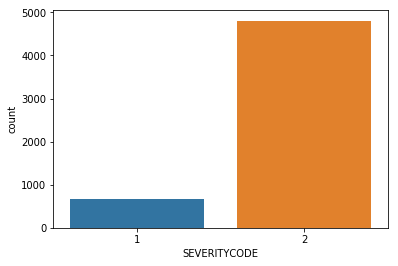

In [70]:
sns.countplot(x='SEVERITYCODE', data=bike_data)

## Persons and Vehicles

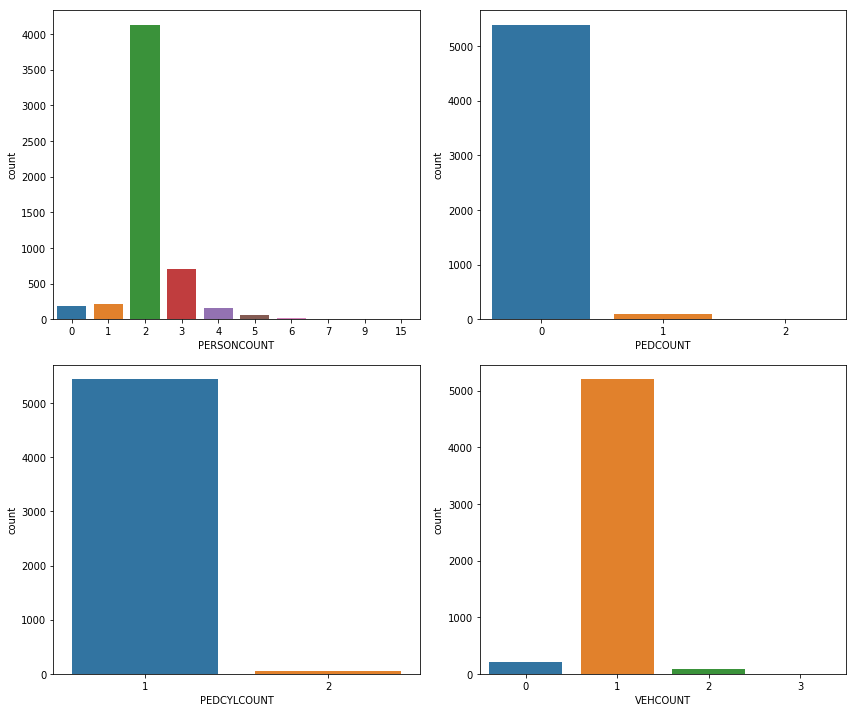

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))

sns.countplot(x='PERSONCOUNT', data=bike_data, ax=ax[0,0])
sns.countplot(x='PEDCOUNT', data=bike_data, ax=ax[0,1])
sns.countplot(x='PEDCYLCOUNT', data=bike_data, ax=ax[1,0])
sns.countplot(x='VEHCOUNT', data=bike_data, ax=ax[1,1])

plt.tight_layout()

## Road and Weather Conditions

Feature elements were combined to create a more efficient model.

In [8]:
bike_data['WEATHER'].value_counts()

Clear                       3953
Overcast                     800
Raining                      597
Unknown                      113
Other                          7
Fog/Smog/Smoke                 5
Snowing                        2
Blowing Sand/Dirt              1
Sleet/Hail/Freezing Rain       1
Name: WEATHER, dtype: int64

In [10]:
bike_data['WEATHER'].replace({
    'Fog/Smog/Smoke':'Precipitation/Low Visibility',
    'Snowing':'Precipitation/Low Visibility',
    'Sleet/Hail/Freezing Rain':'Precipitation/Low Visibility',
    'Blowing Sand/Dirt':'Precipitation/Low Visibility',
    'Raining':'Precipitation/Low Visibility',
    'Other','Unknown'},inplace=True)
bike_data['WEATHER'].value_counts()

Clear                           3953
Overcast                         800
Precipitation/Low Visibility     606
Unknown                          120
Name: WEATHER, dtype: int64

In [11]:
bike_data['ROADCOND'].value_counts()

Dry               4402
Wet                934
Unknown            122
Ice                 10
Snow/Slush           4
Standing Water       3
Sand/Mud/Dirt        2
Other                2
Name: ROADCOND, dtype: int64

In [12]:
bike_data['ROADCOND'].replace({
    'Other':'Unknown',
    'Standing Water':'Wet',
    'Snow/Slush':'Ice',
    'Sand/Mud/Dirt':'Wet'},inplace=True)

Dry        4402
Wet         939
Unknown     124
Ice          14
Name: ROADCOND, dtype: int64

In [52]:
bike_data['LIGHTCOND'].value_counts()

Daylight                   4085
Dark - Street Lights On     917
Twilight                    318
Unknown                      96
Dark - No Street Lights      62
Name: LIGHTCOND, dtype: int64

In [14]:
bike_data['LIGHTCOND'].replace({
    'Dusk':'Twilight',
    'Dawn':'Twilight',
    'Other':'Unknown',
    'Dark - Unknown Lighting':'Unknown',
    'Dark - Street Lights Off':'Dark - No Street Lights'},inplace=True)

Daylight                   4085
Dark - Street Lights On     917
Twilight                    318
Unknown                      96
Dark - No Street Lights      62
Name: LIGHTCOND, dtype: int64

#### After looking through more detailed descriptions of the incidents, it was determined that the secondary "relationship" to an intersection or the middle of a block was not substantial enough to warrant an additional category.

In [53]:
bike_data['JUNCTIONTYPE'].value_counts()

At Intersection           3138
Mid-Block                 1735
Ramp/Driveway Junction     572
Name: JUNCTIONTYPE, dtype: int64

In [16]:
bike_data['JUNCTIONTYPE'].replace({
    'Ramp Junction':'Ramp/Driveway Junction',
    'Driveway Junction':'Ramp/Driveway Junction',
    'At Intersection (intersection related)':'At Intersection',
    'At Intersection (but not related to intersection)':'At Intersection',
    'Mid-Block (not related to intersection)':'Mid-Block',
    'Mid-Block (but intersection related)':'Mid-Block'},inplace=True)

At Intersection           3138
Mid-Block                 1735
Ramp/Driveway Junction     572
Name: JUNCTIONTYPE, dtype: int64

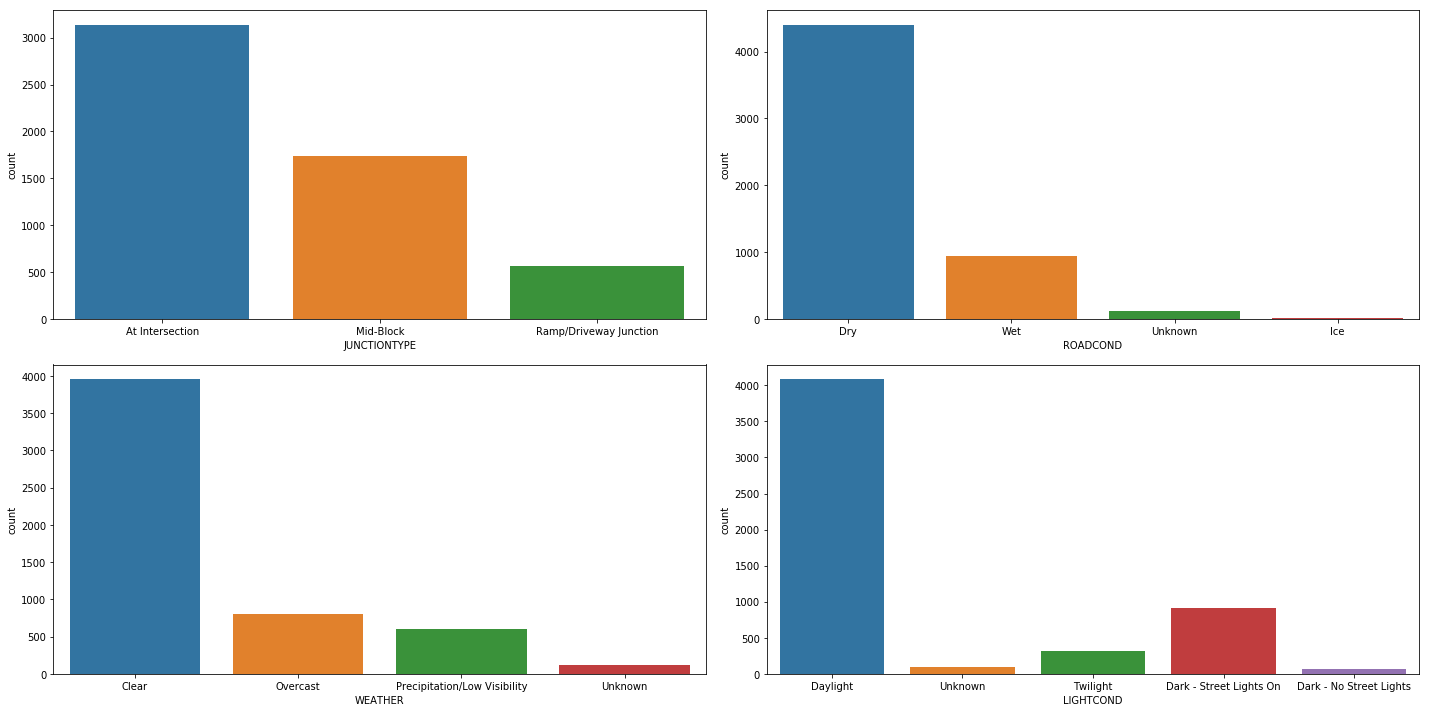

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))


sns.countplot(x='JUNCTIONTYPE',data=bike_data,ax=ax[0,0])
sns.countplot(x='WEATHER', data=bike_data, ax=ax[1,0])
sns.countplot(x='LIGHTCOND', data=bike_data, ax=ax[1,1])
sns.countplot(x='ROADCOND', data=bike_data, ax=ax[0,1])

plt.tight_layout()

In [17]:
bike_data.head()

,SEVERITYCODE,OBJECTID,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,ROADCOND,LIGHTCOND,WEATHER,ST_COLCODE,ST_COLDESC,Lat,Lng
7,2,9,Cycles,3,0,1,1,4/15/2020 5:47:00 PM,At Intersection,Dry,Daylight,Clear,5,Vehicle Strikes Pedalcyclist,-122.320780,47.614076
25,2,34,Cycles,2,0,1,1,4/25/2019 9:40:00 AM,Mid-Block,Dry,Daylight,Clear,5,Vehicle Strikes Pedalcyclist,-122.312857,47.599218
52,2,62,Cycles,3,0,1,1,3/29/2013 11:53:00 AM,At Intersection,Dry,Unknown,Clear,45,Vehicle - Pedalcyclist,-122.328913,47.613466
79,1,91,Cycles,2,0,1,1,3/28/2013 3:30:00 PM,At Intersection,Dry,Daylight,Clear,45,Vehicle - Pedalcyclist,-122.312464,47.652976
90,2,103,Other,1,0,1,0,10/11/2004 4:00:00 PM,Mid-Block,Dry,Daylight,Clear,52,Vehicle overturned,-122.337054,47.695963


## Date and Time

The individual elements of the datetime were broken out to engineer better features for our model.

In [18]:
bike_data['INCDTTM'] = pd.to_datetime(bike_data['INCDTTM'])

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
bike_data['INCYEAR'] = bike_data['INCDTTM'].dt.year
bike_data['INCMONTH'] = bike_data['INCDTTM'].dt.month
bike_data['INCDOW'] = bike_data['INCDTTM'].dt.dayofweek
bike_data['INCHOUR'] = bike_data['INCDTTM'].dt.hour

bike_data['INCWKND'] = bike_data['INCDOW'].apply(lambda x: 1 if (x>3) else 0)

bike_data.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,SEVERITYCODE,OBJECTID,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,ROADCOND,...,WEATHER,ST_COLCODE,ST_COLDESC,Lat,Lng,INCYEAR,INCMONTH,INCDOW,INCHOUR,INCWKND
7,2,9,Cycles,3,0,1,1,2020-04-15 17:47:00,At Intersection,Dry,...,Clear,5,Vehicle Strikes Pedalcyclist,-122.320780,47.614076,2020,4,2,17,0
25,2,34,Cycles,2,0,1,1,2019-04-25 09:40:00,Mid-Block,Dry,...,Clear,5,Vehicle Strikes Pedalcyclist,-122.312857,47.599218,2019,4,3,9,0
52,2,62,Cycles,3,0,1,1,2013-03-29 11:53:00,At Intersection,Dry,...,Clear,45,Vehicle - Pedalcyclist,-122.328913,47.613466,2013,3,4,11,1
79,1,91,Cycles,2,0,1,1,2013-03-28 15:30:00,At Intersection,Dry,...,Clear,45,Vehicle - Pedalcyclist,-122.312464,47.652976,2013,3,3,15,0
90,2,103,Other,1,0,1,0,2004-10-11 16:00:00,Mid-Block,Dry,...,Clear,52,Vehicle overturned,-122.337054,47.695963,2004,10,0,16,0


#### The hours of the day in particular presented an opportunity to create a very telling feature for 'Time of Day' which would coincide with traditional American rush hour time periods and the intervals there between.

In [20]:
periods = {0:'Late Night',
           1:'Late Night',
           2:'Late Night',
           3:'Late Night',
           4:'Late Night',
           5:'Late Night',
           6:'Morning Rush',
           7:'Morning Rush',
           8:'Morning Rush',
           9:'Morning Rush',
           10:'Midday',
           11:'Midday',
           12:'Midday',
           13:'Midday',
           14:'Midday',
           15:'Afternoon Rush',
           16:'Afternoon Rush',
           17:'Afternoon Rush',
           18:'Afternoon Rush',
           19:'Evening',
           20:'Evening',
           21:'Evening',
           22:'Late Night',
           23:'Late Night'}

df = pd.Series(periods, name='INCTOD')
df.index.name = 'Hour'
df2 = df.reset_index()
df2

In [22]:
bike_data = pd.merge(bike_data,df2,left_on = 'INCHOUR',right_on='Hour',how='left')
bike_data.drop('Hour',axis=1,inplace=True)

,SEVERITYCODE,OBJECTID,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,JUNCTIONTYPE,ROADCOND,...,ST_COLCODE,ST_COLDESC,Lat,Lng,INCYEAR,INCMONTH,INCDOW,INCHOUR,INCWKND,INCTOD
0,2,9,Cycles,3,0,1,1,2020-04-15 17:47:00,At Intersection,Dry,...,5,Vehicle Strikes Pedalcyclist,-122.320780,47.614076,2020,4,2,17,0,Afternoon Rush
1,2,34,Cycles,2,0,1,1,2019-04-25 09:40:00,Mid-Block,Dry,...,5,Vehicle Strikes Pedalcyclist,-122.312857,47.599218,2019,4,3,9,0,Morning Rush
2,2,62,Cycles,3,0,1,1,2013-03-29 11:53:00,At Intersection,Dry,...,45,Vehicle - Pedalcyclist,-122.328913,47.613466,2013,3,4,11,1,Midday
3,1,91,Cycles,2,0,1,1,2013-03-28 15:30:00,At Intersection,Dry,...,45,Vehicle - Pedalcyclist,-122.312464,47.652976,2013,3,3,15,0,Afternoon Rush
4,2,103,Other,1,0,1,0,2004-10-11 16:00:00,Mid-Block,Dry,...,52,Vehicle overturned,-122.337054,47.695963,2004,10,0,16,0,Afternoon Rush


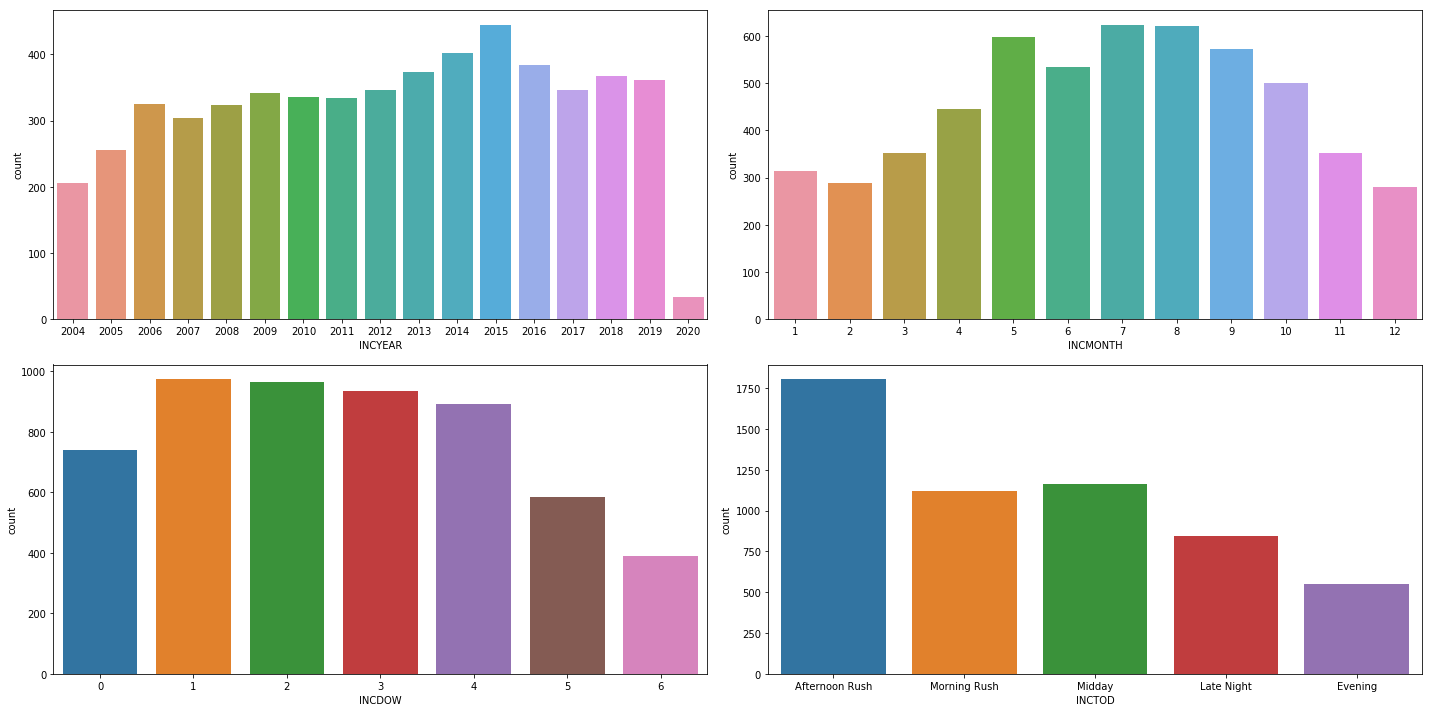

In [91]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

sns.countplot(x='INCYEAR', data=bike_data, ax=ax[0,0])
sns.countplot(x='INCMONTH', data=bike_data, ax=ax[0,1])
sns.countplot(x='INCDOW', data=bike_data, ax=ax[1,0])
sns.countplot(x='INCTOD', data=bike_data, ax=ax[1,1])

plt.tight_layout()

#### As can be seen below, accidents with only property damage remain fairly consistent over time with injury related accidents causing the spikes.

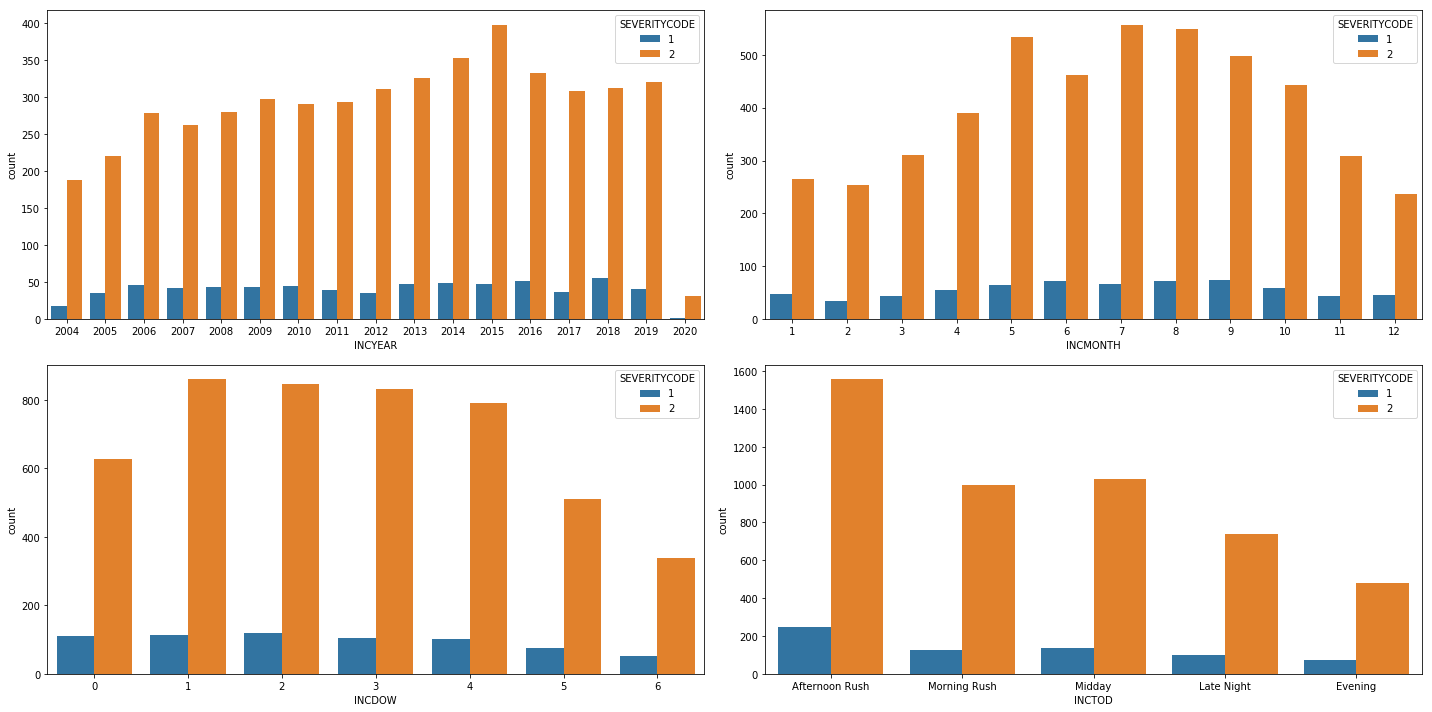

In [92]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

sns.countplot(x='INCYEAR', hue='SEVERITYCODE', data=bike_data, ax=ax[0,0])
sns.countplot(x='INCMONTH', hue='SEVERITYCODE', data=bike_data, ax=ax[0,1])
sns.countplot(x='INCDOW', hue='SEVERITYCODE', data=bike_data, ax=ax[1,0])
sns.countplot(x='INCTOD', hue='SEVERITYCODE', data=bike_data, ax=ax[1,1])

plt.tight_layout()

## Feature Selection and Preprocessing

In [31]:
Feature = bike_data[['SEVERITYCODE','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT','JUNCTIONTYPE','ROADCOND','LIGHTCOND','WEATHER','INCMONTH','INCWKND','INCTOD','Lat','Lng']]
Feature.head()

,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,ROADCOND,LIGHTCOND,WEATHER,INCMONTH,INCWKND,INCTOD,Lat,Lng
0,2,3,0,1,1,At Intersection,Dry,Daylight,Clear,4,0,Afternoon Rush,-122.320780,47.614076
1,2,2,0,1,1,Mid-Block,Dry,Daylight,Clear,4,0,Morning Rush,-122.312857,47.599218
2,2,3,0,1,1,At Intersection,Dry,Unknown,Clear,3,1,Midday,-122.328913,47.613466
3,1,2,0,1,1,At Intersection,Dry,Daylight,Clear,3,0,Afternoon Rush,-122.312464,47.652976
4,2,1,0,1,0,Mid-Block,Dry,Daylight,Clear,10,0,Afternoon Rush,-122.337054,47.695963


#### The categorical variables were encoded to continuous variables.

In [32]:
LE = LabelEncoder()
for i in Feature:
    if Feature[i].dtype == 'object':
        Feature[i] = LE.fit_transform(Feature[i].astype(str))
        
Feature.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,ROADCOND,LIGHTCOND,WEATHER,INCMONTH,INCWKND,INCTOD,Lat,Lng
0,2,3,0,1,1,0,0,2,0,4,0,0,-122.320780,47.614076
1,2,2,0,1,1,1,0,2,0,4,0,4,-122.312857,47.599218
2,2,3,0,1,1,0,0,4,0,3,1,3,-122.328913,47.613466
3,1,2,0,1,1,0,0,2,0,3,0,0,-122.312464,47.652976
4,2,1,0,1,0,1,0,2,0,10,0,0,-122.337054,47.695963


#### The Feature was then split into training and test sets.

In [33]:
x_train, x_test, y_train, y_test = train_test_split(Feature.drop('SEVERITYCODE',axis=1), Feature.SEVERITYCODE, test_size=0.2, random_state=4)

for i in x_train, x_test, y_train, y_test:
    print(i.shape)

(4387, 13)
(1097, 13)
(4387,)
(1097,)


#### And the X-values were then standardized.

In [34]:
x = x_train.values
x = np.nan_to_num(x)
X = StandardScaler().fit_transform(x)

test_x = x_test.values
test_x = np.nan_to_num(test_x)
X_test = StandardScaler().fit_transform(test_x)

array([[-2.72920492, -0.12364331, -0.08967876, ..., -0.56108022,
        -0.08571376,  0.07891686],
       [ 1.12435864, -0.12364331, -0.08967876, ..., -1.20108514,
        -0.08760495,  0.08210751],
       [-0.16016255, -0.12364331, -0.08967876, ...,  1.35893455,
        -0.08720485,  0.08127532],
       ...,
       [ 1.12435864, -0.12364331, -0.08967876, ...,  1.35893455,
        -0.08390783,  0.0941491 ],
       [ 1.12435864, -0.12364331, -0.08967876, ...,  0.0789247 ,
        -0.08513439,  0.0836653 ],
       [-0.16016255, -0.12364331, -0.08967876, ...,  0.0789247 ,
        -0.08655727,  0.08086343]])

## Modeling

Decision Tree and Logistic Regression algorithms were run.

In [35]:
dtc = DecisionTreeClassifier(criterion='entropy').fit(X,y_train)

#solvers = [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]
LR = LogisticRegression(C=.01, solver='lbfgs').fit(X,y_train)

In [39]:
yhat_DT = dtc.predict(X_test)
yhat_LR = LR.predict(X_test)
yhat_LR_prob = LR.predict_proba(X_test)

DT_JI = jaccard_similarity_score(y_test, yhat_DT)
DT_F1 = f1_score(y_test, yhat_DT, average='weighted')
LR_JI = jaccard_similarity_score(y_test, yhat_LR)
LR_F1 = f1_score(y_test, yhat_LR, average='weighted')
LR_LL = log_loss(y_test, yhat_LR_prob)

data = [['Decision Tree', DT_JI, DT_F1, np.nan],['LogisticRegression', LR_JI, LR_F1, LR_LL]]
table = pd.DataFrame(data, columns=['Algorithm', 'JaccardIndex', 'F1 Score', 'Log Loss']).set_index('Algorithm')
table

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,JaccardIndex,F1 Score,Log Loss
Algorithm,,,
Decision Tree,0.812215,0.808360,NaN
LogisticRegression,0.878760,0.822052,0.361114


#### The Logistic Regression model had a higher accuracy, but the feature importances were then split out to see which features worked better in which model.

In [40]:
DT_imp = pd.DataFrame(data={'importance':dtc.feature_importances_,'features':Feature.columns[1:]}).set_index('features')
DT_imp = DT_imp.sort_values('importance',ascending=False)
DT_imp

,importance
features,
Lat,0.313437
Lng,0.266844
INCMONTH,0.136723
INCTOD,0.086181
JUNCTIONTYPE,0.046661
LIGHTCOND,0.040642
INCWKND,0.032307
WEATHER,0.027715
PERSONCOUNT,0.021903


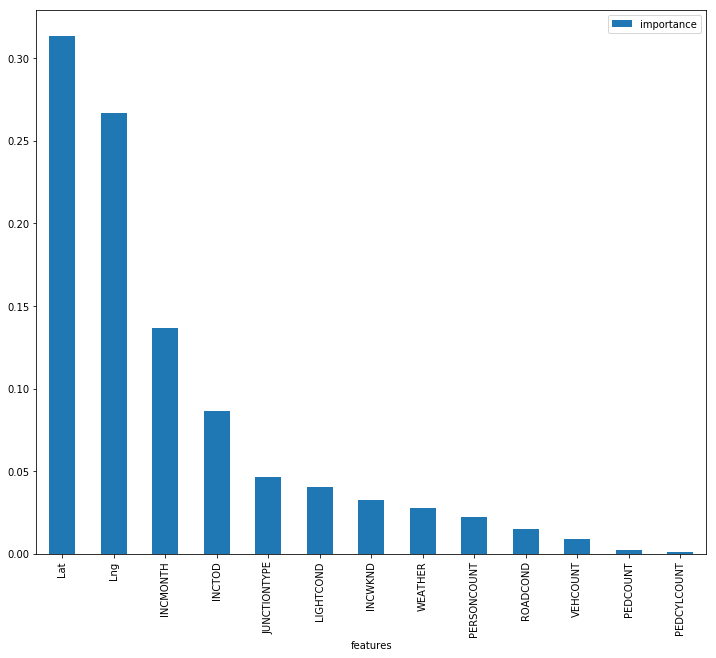

In [41]:
DT_imp.plot(kind='bar',figsize=(12,10))

In [42]:
LR_imp = pd.DataFrame(data={'importance':LR.coef_[0],'features':Feature.columns[1:]}).set_index('features')
LR_imp = LR_imp.sort_values('importance',ascending=False)
LR_imp

,importance
features,
PEDCYLCOUNT,0.121389
INCTOD,0.069298
PEDCOUNT,0.054632
PERSONCOUNT,0.033537
INCWKND,0.023766
INCMONTH,0.013426
Lng,0.002140
Lat,0.001752
ROADCOND,-0.001271


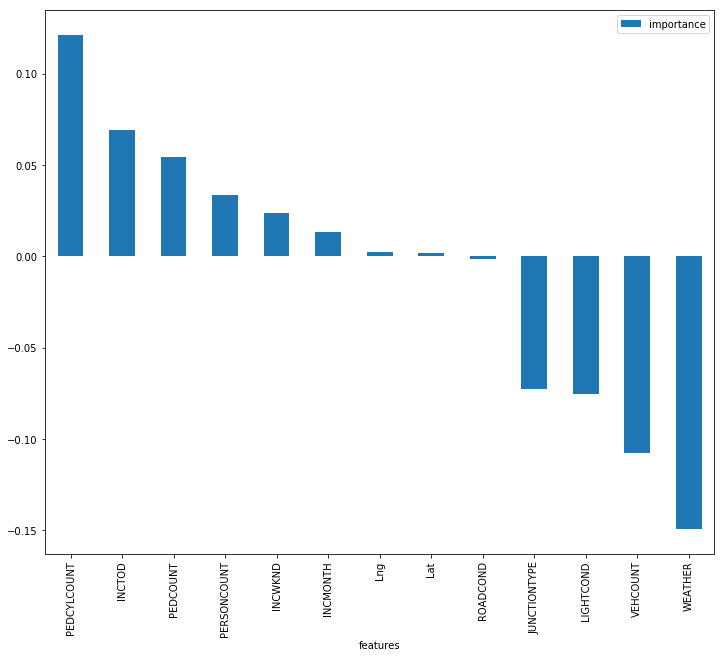

In [43]:
LR_imp.plot(kind='bar',figsize=(12,10))

# Conclusion

Most bicycle collisions occur during daylight hours with clear skies and dry roads, so the those features turned out to be nearly negligible in determinging whether an accident would incur an injury or just property damage. What mattered more in the two models were the datetime features with the engineered feature for Time of Day being notably important in both.

